In [1]:
%%capture
!rm -rf data/
!mkdir data
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/lndst/v0.1/train_images.zip
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/lndst/v0.1/train_gt.zip
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/lndst/v0.1/test_images.zip
!unzip train_images -d data/
!unzip train_gt -d data/
!unzip test_images -d data/

In [2]:
import warnings
import torch
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fastai import *
from fastai.vision import *
from fastai.callbacks import *

%matplotlib inline

In [3]:
torch.cuda.device(0)
warnings.filterwarnings("ignore")
torch.multiprocessing.freeze_support()
print("[INFO] GPU:", torch.cuda.get_device_name())

[INFO] GPU: Tesla P100-PCIE-16GB


In [4]:
torch.cuda.empty_cache()

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [6]:
ROOT = Path("/content/data/")
MODELROOT = Path("/content/drive/My Drive/Competition/LNDST/")

!ls "/content/data"

test_images  train_gt  train_images


## **Data Loading**

In [7]:
get_y_fn = lambda x: ROOT/"train_gt/"/(x.stem+".png")
data_list = SegmentationItemList.from_folder(path=ROOT/'train_images').split_by_rand_pct(0.2).label_from_func(get_y_fn, classes=np.array(['land','water']))

def get_data(image_size, batch_size):
    tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=10.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75)
    data = (data_list.transform(
            tfms=tfms,
            tfm_y=True,
            size=image_size,
            resize_method=ResizeMethod.SQUISH)
                .databunch(bs=batch_size)
                .normalize(imagenet_stats))
    data.num_workers = 4
    return data

In [ ]:
temp = get_data(64, 4)
temp

ImageDataBunch;

Train: LabelList (1120 items)
x: SegmentationItemList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: SegmentationLabelList
ImageSegment (1, 64, 64),ImageSegment (1, 64, 64),ImageSegment (1, 64, 64),ImageSegment (1, 64, 64),ImageSegment (1, 64, 64)
Path: /content/data/train_images;

Valid: LabelList (279 items)
x: SegmentationItemList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: SegmentationLabelList
ImageSegment (1, 64, 64),ImageSegment (1, 64, 64),ImageSegment (1, 64, 64),ImageSegment (1, 64, 64),ImageSegment (1, 64, 64)
Path: /content/data/train_images;

Test: None

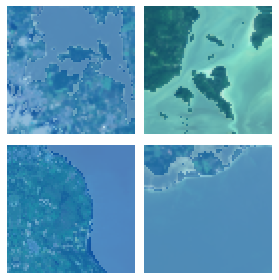

In [ ]:
temp.show_batch(2, figsize=((4,4)))

## **Training**

In [8]:
BATCH_SIZE = 1

In [22]:
def acc(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

## Train 64

In [ ]:
learn = unet_learner(get_data(64, BATCH_SIZE), models.resnet50, metrics=acc, pretrained=True, wd=1e-2)
learn.model_dir = MODELROOT/'checkpoints'
learn.save('resnet_64')

In [ ]:
# Find LR1
print("[INFO] Finding LR1... ")
learn.lr_find()
print("WAITING")
time.sleep(5)
learn.recorder.plot(suggestion=True)

## Train 128

In [ ]:
learn = unet_learner(get_data(128, BATCH_SIZE), models.resnet50, metrics=acc, pretrained=True, wd=1e-2)
learn.model_dir = MODELROOT/'checkpoints'
learn.load("resnet_64")
learn.save('resnet_128')

In [ ]:
# Find LR1
print("[INFO] Finding LR1... ")
learn.lr_find()
print("WAITING")
time.sleep(5)
learn.recorder.plot(suggestion=True)

## Train 256

In [ ]:
learn = unet_learner(get_data(256, BATCH_SIZE), models.resnet50, metrics=acc, pretrained=True, wd=1e-2)
learn.model_dir = MODELROOT/'checkpoints'
learn.load("resnet_128")
learn.save('resnet_256')

In [ ]:
# Find LR1
print("[INFO] Finding LR1... ")
learn.lr_find()
print("WAITING")
time.sleep(5)
learn.recorder.plot(suggestion=True)

## Train 400

In [23]:
learn = unet_learner(get_data(400, BATCH_SIZE), models.resnet50, metrics=acc, pretrained=True, wd=1e-2)
learn.model_dir = MODELROOT/'checkpoints'
# learn.load("resnet_256")
learn.save('resnet_400')

[INFO] Finding LR1... 


epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
WAITING
Min numerical gradient: 1.10E-04
Min loss divided by 10: 2.29E-05


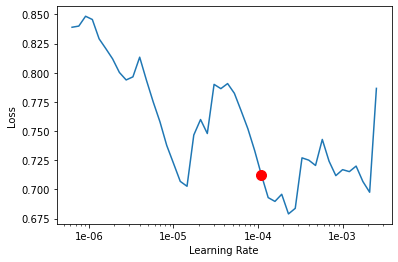

In [ ]:
# Find LR1
print("[INFO] Finding LR1... ")
learn.lr_find()
print("WAITING")
time.sleep(5)
learn.recorder.plot(suggestion=True)

In [ ]:
# Train 1
print("[INFO] Training 1: ")
learn.fit_one_cycle(cyc_len=6, max_lr=1.1e-4, callbacks=[ShowGraph(learn),
                                                        SaveModelCallback(learn, monitor='acc', mode='max', name='resnet_400')])

In [ ]:
# Find LR2 after unfreezing
learn.load("resnet_400")
learn.unfreeze()
print("[INFO] Finding LR2... ")
learn.lr_find()
print("WAITING")
time.sleep(5)
learn.recorder.plot(suggestion=True)

In [ ]:
print("[INFO] Training 2: ")
learn.fit_one_cycle(cyc_len=4, max_lr=X, callbacks=[ShowGraph(learn),
                                                    SaveModelCallback(learn, monitor='f_beta', mode='max', name='resnet_400a')])